#Mounting Google Drive

In [1]:
####### Mouting Drive #######
from google.colab import drive
drive.mount('/content/drive')
!ls

Mounted at /content/drive
drive  sample_data


#Unzip all Images

In [2]:
!unzip "/content/drive/MyDrive/Brain Tumor/archive.zip"

Streaming output truncated to the last 5000 lines.
  inflating: archive/Training/glioma/Tr-gl_0715.jpg  
  inflating: archive/Training/glioma/Tr-gl_0716.jpg  
  inflating: archive/Training/glioma/Tr-gl_0717.jpg  
  inflating: archive/Training/glioma/Tr-gl_0718.jpg  
  inflating: archive/Training/glioma/Tr-gl_0719.jpg  
  inflating: archive/Training/glioma/Tr-gl_0720.jpg  
  inflating: archive/Training/glioma/Tr-gl_0721.jpg  
  inflating: archive/Training/glioma/Tr-gl_0722.jpg  
  inflating: archive/Training/glioma/Tr-gl_0723.jpg  
  inflating: archive/Training/glioma/Tr-gl_0724.jpg  
  inflating: archive/Training/glioma/Tr-gl_0725.jpg  
  inflating: archive/Training/glioma/Tr-gl_0726.jpg  
  inflating: archive/Training/glioma/Tr-gl_0727.jpg  
  inflating: archive/Training/glioma/Tr-gl_0728.jpg  
  inflating: archive/Training/glioma/Tr-gl_0729.jpg  
  inflating: archive/Training/glioma/Tr-gl_0730.jpg  
  inflating: archive/Training/glioma/Tr-gl_0731.jpg  
  inflating: archive/Training/g

In [3]:
# Existing imports
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.models import Sequential
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input as pi
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.losses import categorical_crossentropy
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob

In [4]:
IMAGE_SIZE = [224, 224]
train_path = '/content/archive/Training'
valid_path = '/content/archive/Testing'

vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

for layer in vgg.layers:
    layer.trainable = False

x = Flatten()(vgg.output)
prediction = Dense(len(glob('/content/archive/Testing/*')), activation='softmax')(x)
model = Model(inputs=vgg.input, outputs=prediction)


58889256/58889256 [==============================] - 0s 0us/step


In [5]:
def physics_informed_loss(y_true, y_pred, alpha=0.1):
    classification_loss = categorical_crossentropy(y_true, y_pred)
    physics_loss = physics_model(y_pred)  # Physics loss based on predicted tumor size
    combined_loss = classification_loss + alpha * physics_loss
    return combined_loss

def physics_model(y_pred):
    # Hypothetical physics-based loss
    # Larger predicted sizes should have lower growth rates (simplified assumption)
    predicted_size = tf.reduce_mean(y_pred, axis=1)  # Simplified representation of size
    growth_rate_penalty = tf.square(predicted_size)  # Penalize larger sizes
    physics_loss = tf.reduce_mean(growth_rate_penalty)
    return physics_loss


In [6]:
model.compile(
    optimizer='adam',
    loss=lambda y_true, y_pred: physics_informed_loss(y_true, y_pred, alpha=0.1),
    metrics=['accuracy']
)


In [7]:
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_path, target_size=(224, 224), batch_size=32, class_mode='categorical')
validation_generator = test_datagen.flow_from_directory(valid_path, target_size=(224, 224), batch_size=32, class_mode='categorical')

history = model.fit(train_generator, validation_data=validation_generator, epochs=15, steps_per_epoch=len(train_generator), validation_steps=len(validation_generator))


Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
Epoch 1/15
179/179 [==============================] - 102s 519ms/step - loss: 0.5623 - accuracy: 0.7962 - val_loss: 0.4300 - val_accuracy: 0.8589
Epoch 2/15
179/179 [==============================] - 88s 489ms/step - loss: 0.3035 - accuracy: 0.8934 - val_loss: 0.5628 - val_accuracy: 0.8146
Epoch 3/15
179/179 [==============================] - 83s 464ms/step - loss: 0.2634 - accuracy: 0.9049 - val_loss: 0.2258 - val_accuracy: 0.9062
Epoch 4/15
179/179 [==============================] - 83s 463ms/step - loss: 0.2057 - accuracy: 0.9270 - val_loss: 0.2201 - val_accuracy: 0.9153
Epoch 5/15
179/179 [==============================] - 81s 454ms/step - loss: 0.1570 - accuracy: 0.9428 - val_loss: 0.2230 - val_accuracy: 0.9108
Epoch 6/15
179/179 [==============================] - 84s 466ms/step - loss: 0.1541 - accuracy: 0.9485 - val_loss: 0.1596 - val_accuracy: 0.9474
Epoch 7/15
179/179 [=========================

In [8]:
# Save the model to the Colab environment
model.save("brain_tumor_classifier_model.h5")


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [9]:
from google.colab import files
files.download('brain_tumor_classifier_model.h5')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

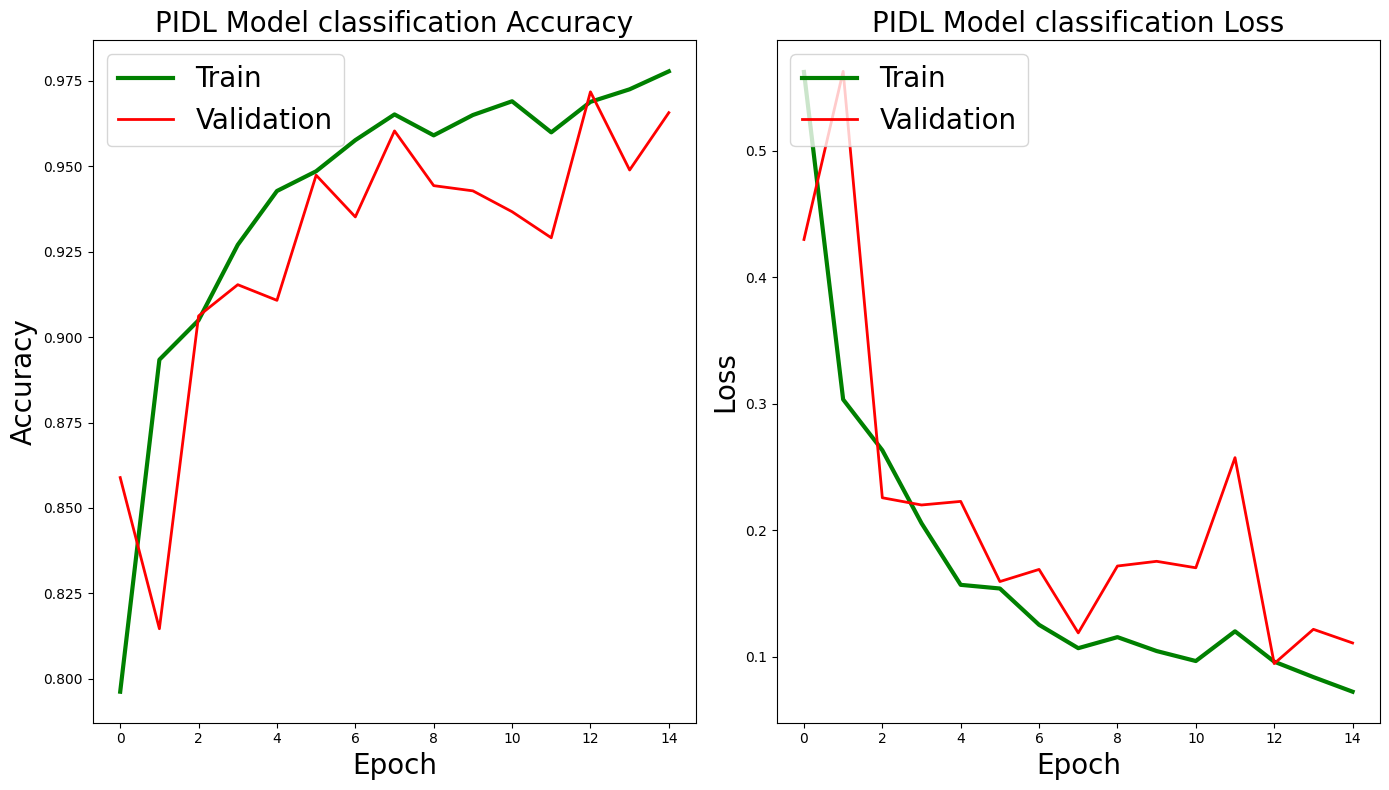

In [28]:
import matplotlib.pyplot as plt

# Set the figure size to be similar to the provided example
plt.figure(figsize=(14, 8))

# Summarize history for accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], 'g-', linewidth=3, label='Train')  # Green for training with bold line
plt.plot(history.history['val_accuracy'], 'r-', linewidth=2, label='Validation')  # Red for validation with bold line
plt.title('PIDL Model classification Accuracy', fontsize=20)
plt.ylabel('Accuracy', fontsize=20)
plt.xlabel('Epoch', fontsize=20)
plt.legend(loc='upper left', prop={'size': 20})

# Summarize history for loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], 'g-', linewidth=3, label='Train')  # Green for training with bold line
plt.plot(history.history['val_loss'], 'r-', linewidth=2, label='Validation')  # Red for validation with bold line
plt.title('PIDL Model classification Loss', fontsize=20)
plt.ylabel('Loss', fontsize=20)
plt.xlabel('Epoch', fontsize=20)
plt.legend(loc='upper left', prop={'size': 20})

# Adjust layout and show plot
plt.tight_layout()
plt.show()


In [29]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Create a Sequential model
model = Sequential()

# Add a convolutional layer with 32 filters, a 3x3 kernel, and ReLU activation
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
# Add a max-pooling layer
model.add(MaxPooling2D((2, 2)))

# Add another convolutional layer with 64 filters, a 3x3 kernel, and ReLU activation
model.add(Conv2D(64, (3, 3), activation='relu'))
# Add another max-pooling layer
model.add(MaxPooling2D((2, 2)))

# Flatten the output from the previous layer
model.add(Flatten())

# Add a fully connected layer with 128 units and ReLU activation
model.add(Dense(128, activation='relu'))
# Add dropout for regularization
model.add(Dropout(0.5))

# Add the output layer with as many units as classes and softmax activation for classification
# Replace `num_classes` with the number of classes in your dataset
num_classes = 4  # Example for 4 classes (glioma, meningioma, no tumor, pituitary)
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print a summary of the model's architecture
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 186624)            0         
                                                                 
 dense_1 (Dense)             (None, 128)               2

In [30]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the directory where your training and validation data are stored
train_data_dir = '/content/archive/Training'
validation_data_dir = '/content/archive/Testing'

# Create data generators for training and validation data
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,  # Normalize pixel values to [0, 1]
    shear_range=0.2,    # Random shear transformations
    zoom_range=0.2,     # Random zoom transformations
    horizontal_flip=True  # Random horizontal flips
)

validation_datagen = ImageDataGenerator(rescale=1.0 / 255)  # Only rescale for validation

# Define batch size and image dimensions
batch_size = 32
image_height = 224
image_width = 224

# Create generators for training and validation data
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode='categorical'
)

# Train the model
epochs = 10  # Choose the number of training epochs
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=len(validation_generator)
)

# Evaluate the model on the validation set
validation_loss, validation_accuracy = model.evaluate(validation_generator, steps=len(validation_generator))
print("Validation Loss:", validation_loss)
print("Validation Accuracy:", validation_accuracy)


Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
Epoch 1/10
179/179 [==============================] - 78s 414ms/step - loss: 1.1610 - accuracy: 0.5324 - val_loss: 0.7389 - val_accuracy: 0.7399
Epoch 2/10
179/179 [==============================] - 78s 438ms/step - loss: 0.7222 - accuracy: 0.7092 - val_loss: 0.6574 - val_accuracy: 0.7452
Epoch 3/10
179/179 [==============================] - 73s 410ms/step - loss: 0.5914 - accuracy: 0.7726 - val_loss: 0.5995 - val_accuracy: 0.7857
Epoch 4/10
179/179 [==============================] - 76s 422ms/step - loss: 0.5523 - accuracy: 0.7925 - val_loss: 0.8859 - val_accuracy: 0.6926
Epoch 5/10
179/179 [==============================] - 74s 416ms/step - loss: 0.4880 - accuracy: 0.8111 - val_loss: 0.5709 - val_accuracy: 0.7742
Epoch 6/10
179/179 [==============================] - 74s 411ms/step - loss: 0.4592 - accuracy: 0.8267 - val_loss: 0.5175 - val_accuracy: 0.7986
Epoch 7/10
179/179 [==========================

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',     # Monitor validation loss
    patience=3,             # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore the best model weights when training stops
)

# Train the model with early stopping
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=[early_stopping]  # Add the early stopping callback
)


Epoch 1/10
179/179 [==============================] - 89s 497ms/step - loss: 0.3313 - accuracy: 0.8750 - val_loss: 0.3345 - val_accuracy: 0.8673
Epoch 2/10
179/179 [==============================] - 93s 518ms/step - loss: 0.3146 - accuracy: 0.8799 - val_loss: 0.3712 - val_accuracy: 0.8535
Epoch 3/10
179/179 [==============================] - 93s 519ms/step - loss: 0.3088 - accuracy: 0.8825 - val_loss: 0.3305 - val_accuracy: 0.8642
Epoch 4/10
179/179 [==============================] - 89s 498ms/step - loss: 0.2892 - accuracy: 0.8906 - val_loss: 0.4180 - val_accuracy: 0.8474
Epoch 5/10
179/179 [==============================] - 92s 516ms/step - loss: 0.2964 - accuracy: 0.8878 - val_loss: 0.3940 - val_accuracy: 0.8444
Epoch 6/10
179/179 [==============================] - 93s 516ms/step - loss: 0.2838 - accuracy: 0.8950 - val_loss: 0.3085 - val_accuracy: 0.8841
Epoch 7/10
179/179 [==============================] - 91s 510ms/step - loss: 0.2649 - accuracy: 0.8992 - val_loss: 0.2980 - val_ac

In [31]:
# Example multi-output model architecture
classification_output = Dense(num_classes, activation='softmax', name='classification')(x)
physics_output = Dense(1, activation='linear', name='physics')(x)  # Adjust as needed
model = Model(inputs=vgg.input, outputs=[classification_output, physics_output])


In [32]:
classification_loss = 'categorical_crossentropy'
physics_loss = 'mean_squared_error'  # Adjust as needed


In [33]:
loss_weights = {'classification': 1.0, 'physics': 0.1}  # Adjust weights as needed


In [36]:
model.compile(
    optimizer='adam',
    loss={'classification': classification_loss, 'physics': physics_loss},
    loss_weights=loss_weights,
    metrics={'classification': 'accuracy', 'physics': 'mae'}  # Adjust metrics as needed
)


Epoch 1/10
179/179 [==============================] - 84s 446ms/step - loss: 0.5660 - classification_loss: 0.5288 - physics_loss: 0.3721 - classification_accuracy: 0.7999 - physics_mae: 0.4650 - val_loss: 0.4241 - val_classification_loss: 0.4026 - val_physics_loss: 0.2156 - val_classification_accuracy: 0.8551 - val_physics_mae: 0.3357
Epoch 2/10
179/179 [==============================] - 87s 487ms/step - loss: 0.3418 - classification_loss: 0.3214 - physics_loss: 0.2042 - classification_accuracy: 0.8801 - physics_mae: 0.3775 - val_loss: 0.4076 - val_classification_loss: 0.3860 - val_physics_loss: 0.2154 - val_classification_accuracy: 0.8749 - val_physics_mae: 0.3269
Epoch 3/10
179/179 [==============================] - 80s 448ms/step - loss: 0.2535 - classification_loss: 0.2330 - physics_loss: 0.2051 - classification_accuracy: 0.9125 - physics_mae: 0.3775 - val_loss: 0.2347 - val_classification_loss: 0.2137 - val_physics_loss: 0.2096 - val_classification_accuracy: 0.9207 - val_physics_m

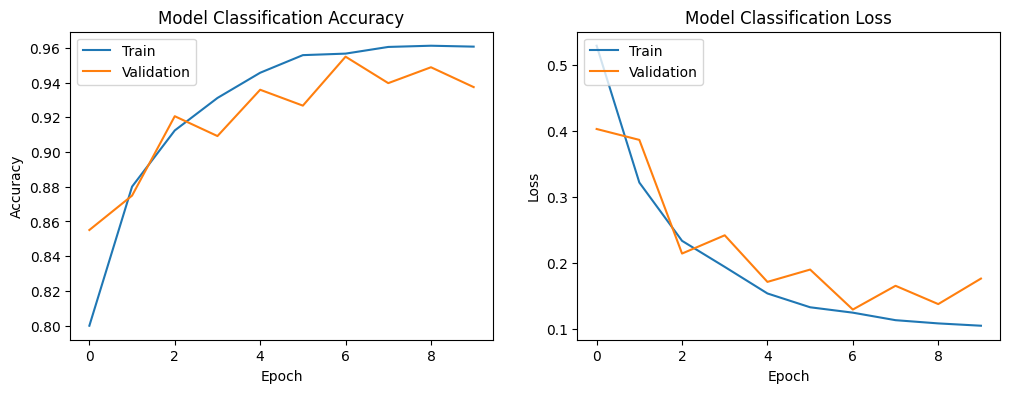

In [38]:
# Training the multi-task model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=len(validation_generator)
)

# Evaluate the multi-task model
eval_metrics = model.evaluate(validation_generator, steps=len(validation_generator))
classification_loss, physics_loss, classification_accuracy = eval_metrics[1], eval_metrics[2], eval_metrics[3]

print("Validation Classification Loss:", classification_loss)
print("Validation Physics Loss:", physics_loss)
print("Validation Classification Accuracy:", classification_accuracy)

# Visualization: Plot training and validation loss and accuracy
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['classification_accuracy'])
plt.plot(history.history['val_classification_accuracy'])
plt.title('Model Classification Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['classification_loss'])
plt.plot(history.history['val_classification_loss'])
plt.title('Model Classification Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


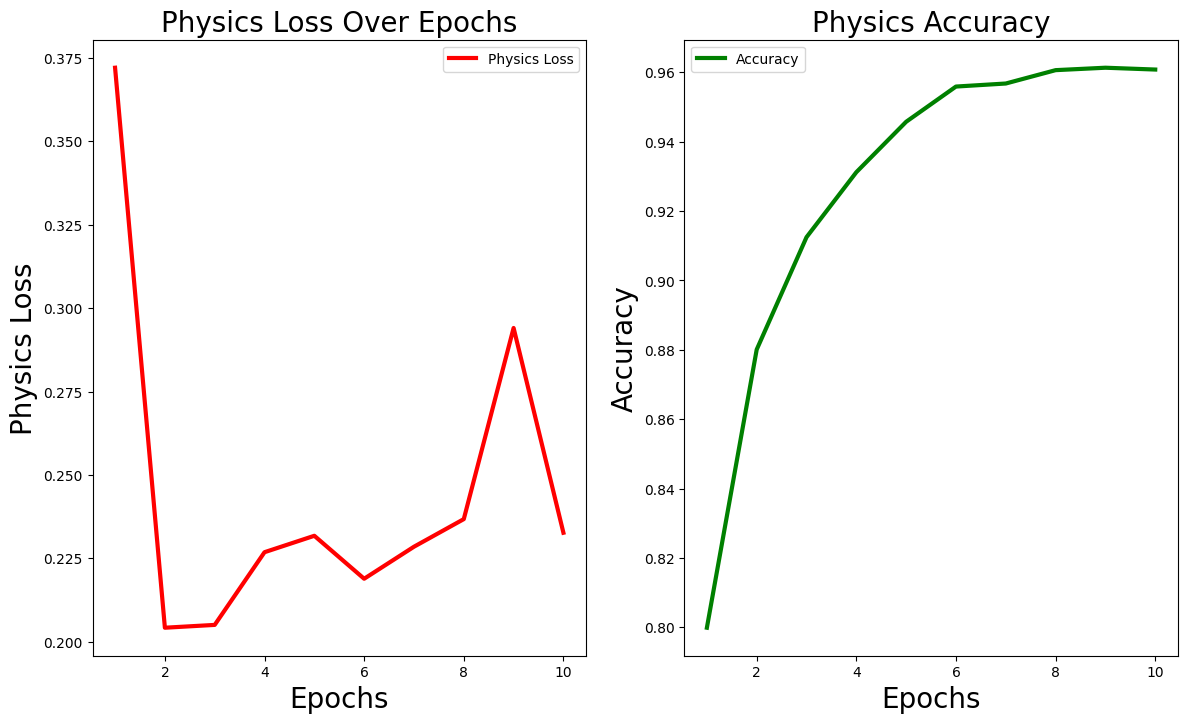

In [48]:
import matplotlib.pyplot as plt

# Extract the physics loss and accuracy from your model's history
physics_loss = history.history['physics_loss']  # Replace with the actual name of your physics loss
accuracy = history.history['classification_accuracy']  # Replace with the actual name of your classification accuracy

# Create subplots to visualize both physics loss and accuracy
plt.figure(figsize=(14, 8))

# Plot physics loss
plt.subplot(1, 2, 1)
epochs = range(1, len(physics_loss) + 1)
plt.plot(epochs, physics_loss, 'r-', label='Physics Loss', linewidth=3)
plt.title('Physics Loss Over Epochs', fontsize=20)
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Physics Loss', fontsize=20)
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy, 'g-', label='Accuracy', linewidth=3)
plt.title('Physics Accuracy', fontsize=20)
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Accuracy', fontsize=20)
plt.legend()



1/1 [==============================] - 0s 28ms/step


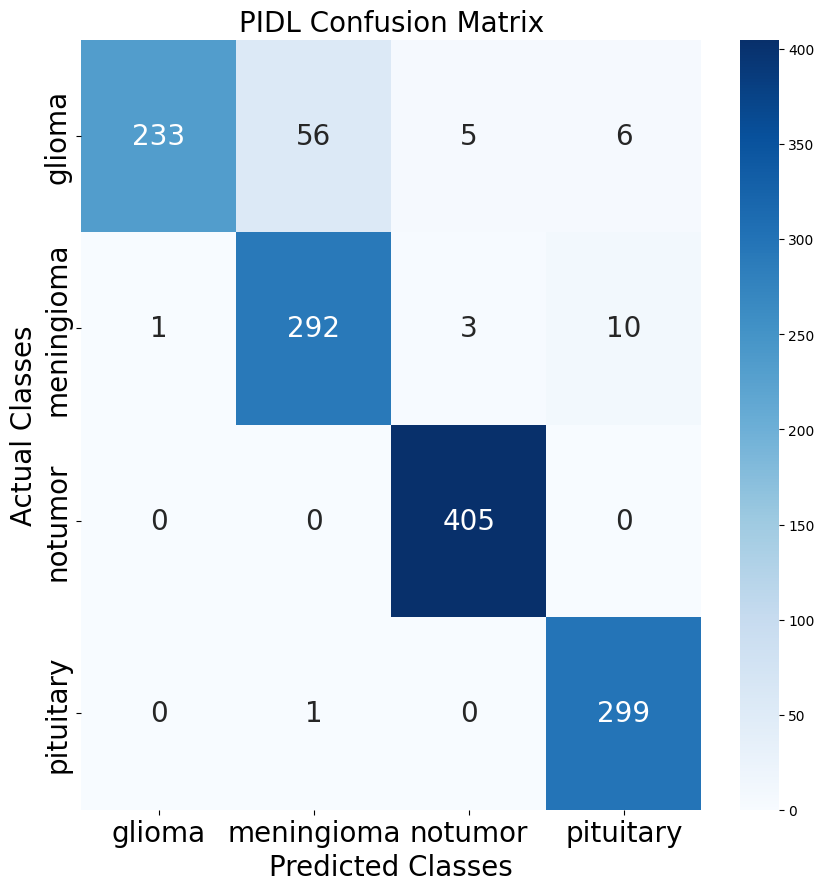

In [56]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Initialize arrays to store true and predicted labels
true_labels = []
pred_labels = []

# Iterate over all batches in the validation generator
for _ in range(len(validation_generator)):
    val_images, val_labels = next(validation_generator)
    # Generate predictions
    predictions = model.predict(val_images)
    # Extract only classification predictions (assuming it's the first element in the list)
    classification_predictions = predictions[0]
    # Convert predictions to class indices
    predicted_classes = np.argmax(classification_predictions, axis=1)
    true_classes = np.argmax(val_labels, axis=1)
    # Store true and predicted labels
    true_labels.extend(true_classes)
    pred_labels.extend(predicted_classes)

# Convert lists to arrays for sklearn functions
true_labels = np.array(true_labels)
pred_labels = np.array(pred_labels)

# Define class labels if you have custom class names
class_labels = ["glioma", "meningioma", "notumor", "pituitary"]  # Replace with your class names

# Create a confusion matrix
conf_matrix = confusion_matrix(true_labels, pred_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels, annot_kws={"size": 20})
plt.title('PIDL Confusion Matrix', fontsize=20)
plt.ylabel('Actual Classes', fontsize=20)
plt.xlabel('Predicted Classes', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()


# LIME with the New Prediction Function

In [57]:
!pip install lime


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=bd271c4d941d64fcfe196921a06885a15c3e8d5cf85203be3d3344e398fbb47c
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [58]:
pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 7.7 MB/s eta 0:00:00


In [59]:
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import numpy as np

# Specify the correct path to your image file
image_path = '/content/archive/Testing/meningioma/Te-meTr_0008.jpg'

# Load, convert, and preprocess the image
image = load_img(image_path, target_size=(224, 224))  # or the input size of your model
image = img_to_array(image)
image = image / 255.0  # Normalize if your model expects data in this format
image = np.expand_dims(image, axis=0)  # Add batch dimension

print("Image shape:", image.shape)  # Should be (1, 224, 224, 3) or similar


Image shape: (1, 224, 224, 3)


In [60]:
def predict_proba(img_array):
    preds = model.predict(img_array)
    # Return only the probabilities array (assuming it's the first output of your model)
    return preds[0]  # Adjust the index if necessary


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step


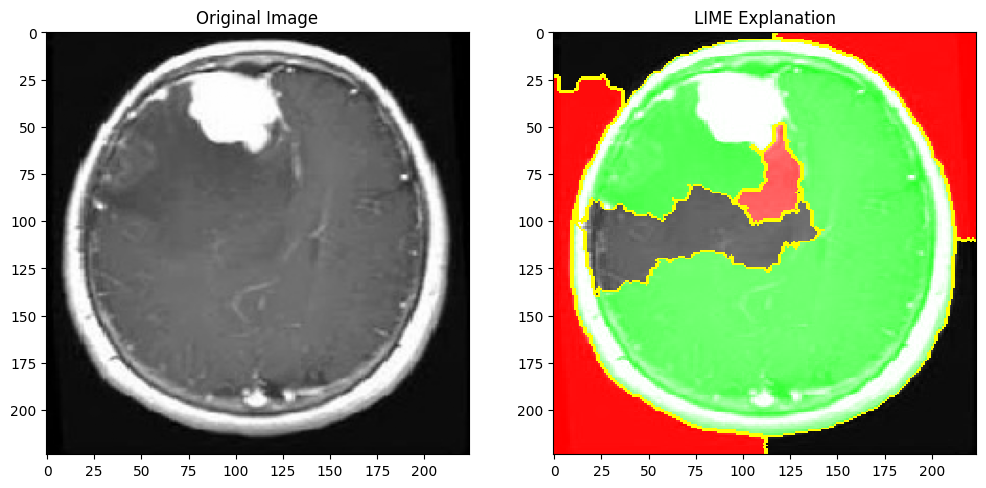

In [61]:
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt

# Initialize LIME Image Explainer
explainer = lime_image.LimeImageExplainer()

# Explain the prediction on the given image
explanation = explainer.explain_instance(image[0], predict_proba, top_labels=5, hide_color=0, num_samples=1000)

# Get explanation mask for the top class
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)

# Create a subplot of 1 row and 2 columns
plt.figure(figsize=(12, 6))

# Plot the original image
plt.subplot(1, 2, 1)
plt.imshow(image[0])
plt.title('Original Image')

# Plot the image with LIME explanation
plt.subplot(1, 2, 2)
# Use 'jet' colormap for more vibrant colors, adjust as needed
plt.imshow(mark_boundaries(temp, mask), cmap='jet', interpolation='nearest')
plt.title('LIME Explanation')

plt.show()


In [62]:
!pip install --upgrade shap


In [63]:
# Assuming 'model' is your preloaded Keras model
for layer in model.layers:
    print(layer.name)


input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool
flatten
classification
physics


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step


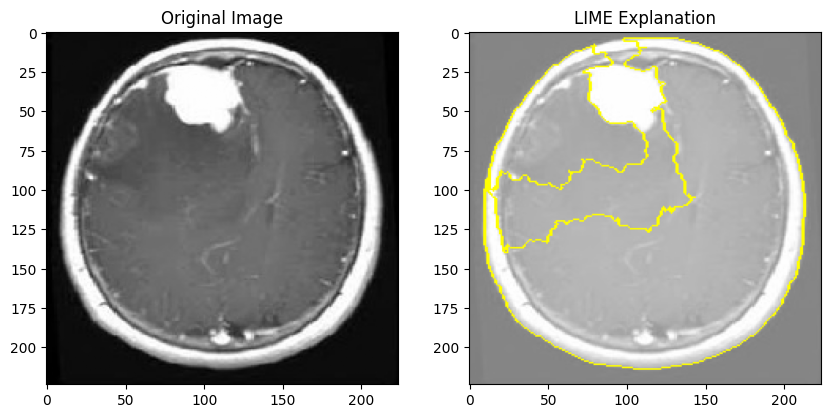

In [64]:
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt

# Initialize LIME Image Explainer
explainer = lime_image.LimeImageExplainer()

# Explain the prediction on the given image
explanation = explainer.explain_instance(image[0],  # Make sure this is a single image, not batch
                                         predict_proba,  # Use the new prediction function
                                         top_labels=5,
                                         hide_color=0,
                                         num_samples=1000)  # Number of images to generate

# Get explanation mask for the top class
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0],
                                            positive_only=True,
                                            num_features=5,
                                            hide_rest=False)

# Create a subplot of 1 row and 2 columns
plt.figure(figsize=(10, 5))

# Plot the original image
plt.subplot(1, 2, 1)
plt.imshow(image[0])  # Assuming the original image is normalized as [0,1]
plt.title('Original Image')

# Plot the image with LIME explanation
plt.subplot(1, 2, 2)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))  # Adjust temp if it was normalized
plt.title('LIME Explanation')

plt.show()


In [ ]:
!pip install shap
!pip install numpy
!pip install tensorflow


In [ ]:
import numpy as np
import shap
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array


In [ ]:
# Load your trained model
model ='/content/brain_tumor_classifier_model.h5 ' # replace with your model

# Function to load and preprocess the image
def load_preprocess_image(image_path):
    image = load_img(image_path, target_size=(224, 224))  # Adjust size to your model's expected input
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)  # Add batch dimension if needed
    image /= 255.0  # Normalize if that's what your model expects
    return image

image_path = '/content/archive/Training/glioma/Tr-glTr_0000.jpg'  # Update with your image path
sample_to_explain = load_preprocess_image(image_path)

# Prepare a background dataset
# background = ... (Your background data, a subset of training or similar images)


In [ ]:
def model_predict(data):
    predictions = model.predict(data)
    # Ensure the predictions are in the correct format for SHAP
    # For example, if you're interested in the first output:
    return predictions
